In [36]:
import numpy as np
import matplotlib.pyplot as plt
import sunpy 
import sunpy.map
from sunpy.coordinates import propagate_with_solar_surface
from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize, AsinhStretch
from astropy.wcs import WCS
from sunkit_image import coalignment
from sun_blinker import SunBlinker, ImageBlinker

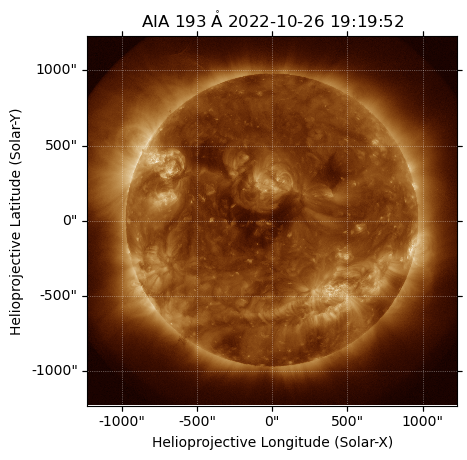

In [2]:
aia_193_map = sunpy.map.Map("../../src/AIA/20221026/193/lvl15/aia.lev1_euv_12s.2022-10-26T191951Z.193.image.fits")
aia_193_map.plot()

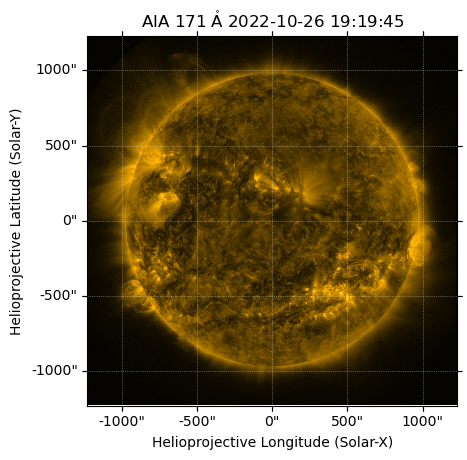

In [3]:
aia_171_map = sunpy.map.Map("../../src/AIA/20221026/171/lvl15/aia.lev1_euv_12s.2022-10-26T191951Z.171.image.fits")
aia_171_map.plot()

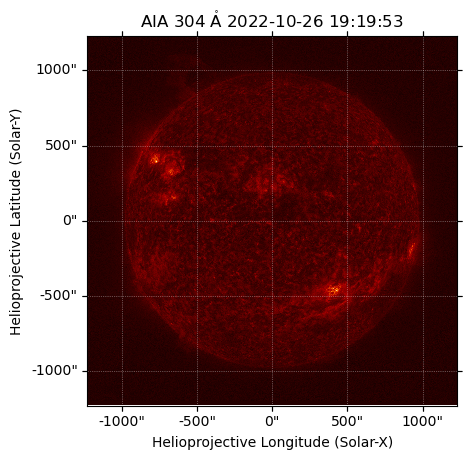

In [4]:
aia_304_map = sunpy.map.Map("../../src/AIA/20221026/304/aia.lev1_euv_12s.2022-10-26T191951Z.304.image.fits")
aia_304_map.plot()

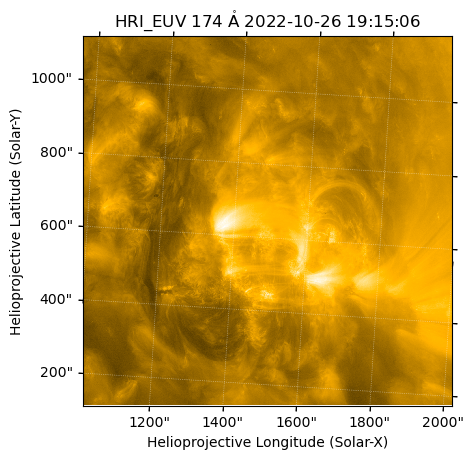

In [5]:
hri_174_map = sunpy.map.Map("../../src/EUI/HRI/euv174/20221026/coalign_step_boxcar/eui_map_seq_coalign_boxcar_181.fits")
hri_174_map.meta["rsun_ref"] = aia_171_map.meta["rsun_ref"]
hri_174_map.plot()

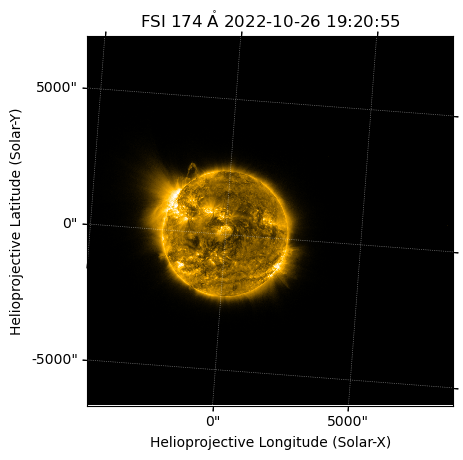

In [6]:
fsi_174_map = sunpy.map.Map("../../src/EUI/FSI/euv174/20221026/solo_L2_eui-fsi174-image_20221026T192050235_V01.fits")
fsi_174_map.meta["rsun_ref"] = aia_171_map.meta["rsun_ref"]
fsi_174_map.plot()

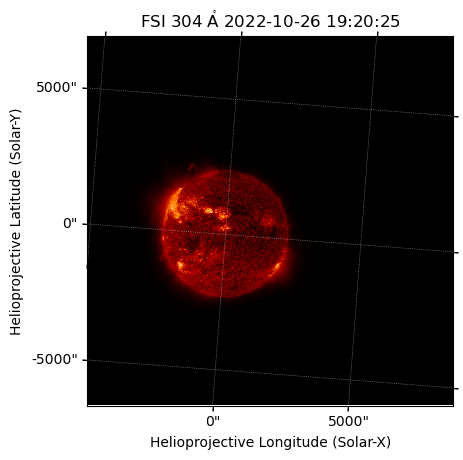

In [7]:
fsi_304_map = sunpy.map.Map("../../src/EUI/FSI/euv304/20221026/solo_L2_eui-fsi304-image_20221026T192020235_V01.fits")
fsi_304_map.meta["rsun_ref"] = aia_171_map.meta["rsun_ref"]
fsi_304_map.plot()

In [8]:
def derotate_fsi(fsi_map, hri_map,algorithm="adaptive"):
    out_frame = hri_map.coordinate_frame
    out_center = SkyCoord(0*u.arcsec, 0*u.arcsec, frame=out_frame)
    header = sunpy.map.make_fitswcs_header(fsi_map.data.shape,
                                        out_center,
                                        scale=u.Quantity(fsi_map.scale),
                                        rotation_matrix=hri_map.rotation_matrix) 
    # correct the tiny rotation matrix difference between FSI and HRI, which simply the coalignment
    out_wcs = WCS(header)

    with propagate_with_solar_surface():
        fsi_map_derot = fsi_map.reproject_to(out_wcs,algorithm=algorithm)

    return fsi_map_derot


In [9]:
fsi_174_map_hri_time = derotate_fsi(fsi_174_map,hri_174_map)

In [10]:
fsi_174_crop = fsi_174_map_hri_time.submap(SkyCoord(900*u.arcsec,100*u.arcsec,frame=fsi_174_map_hri_time.coordinate_frame),
                                    top_right=SkyCoord(1900*u.arcsec,1100*u.arcsec,frame=fsi_174_map_hri_time.coordinate_frame))

In [11]:
hri_174_map_repro = hri_174_map.reproject_to(fsi_174_crop.wcs)

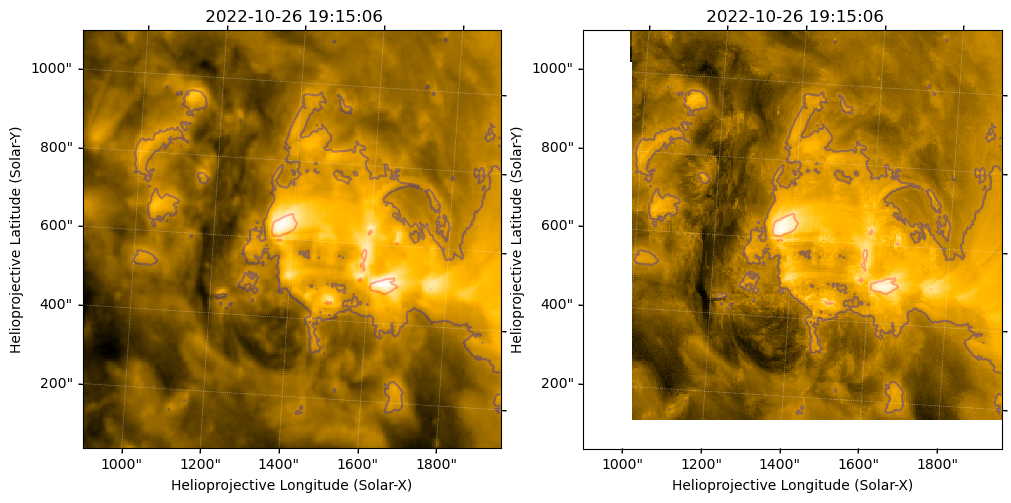

In [12]:
fig = plt.figure(figsize=(10,5),constrained_layout=True)

ax1 = fig.add_subplot(121,projection=fsi_174_crop)
im1 = fsi_174_crop.plot()

ax2 = fig.add_subplot(122,projection=hri_174_map_repro)
im2 = hri_174_map_repro.plot()

hri_levels = [1000,5000]

for ax_ in (ax1,ax2):
    bounds = ax_.axis()
    hri_174_map_repro.draw_contours(hri_levels,colors=["b","r"], axes=ax_, alpha=0.3)
    ax_.axis(bounds)


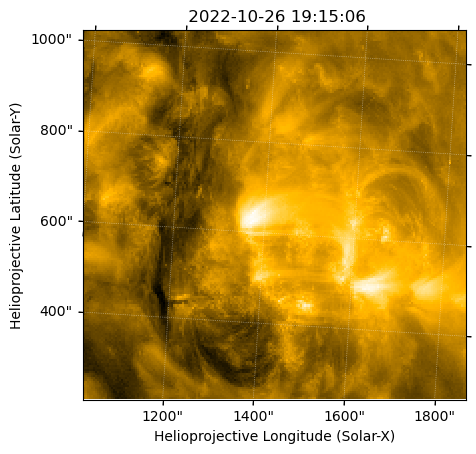

In [13]:
hri_174_map_repro_cut = hri_174_map_repro.submap([30,37]*u.pix,
                                                 top_right=[220,220]*u.pix)
hri_174_map_repro_cut.plot()

In [14]:
def coalign_shift(big_map, small_map):
    yshift, xshift = coalignment._calculate_shift(big_map.data, small_map.data)
    reference_coord = big_map.pixel_to_world(xshift, yshift)
    Txshift = reference_coord.Tx - small_map.bottom_left_coord.Tx
    Tyshift = reference_coord.Ty - small_map.bottom_left_coord.Ty

    return Txshift, Tyshift

In [15]:
Txshift_hri, Tyshift_hri = coalign_shift(fsi_174_crop,hri_174_map_repro_cut)
print(Txshift_hri, Tyshift_hri)

-0.0235313 arcsec 7.82867 arcsec


In [16]:
hri_174_map_shifted = hri_174_map.shift_reference_coord(Txshift_hri,Tyshift_hri)

In [17]:
SunBlinker(hri_174_map_shifted, fsi_174_crop, reproject=True, fps=1)

In [18]:
fsi_304_map_hri_time = derotate_fsi(fsi_304_map,hri_174_map)

In [19]:
fsi_304_crop = fsi_304_map_hri_time.submap(SkyCoord(900*u.arcsec,100*u.arcsec,frame=fsi_304_map_hri_time.coordinate_frame),
                                    top_right=SkyCoord(1900*u.arcsec,1100*u.arcsec,frame=fsi_304_map_hri_time.coordinate_frame))

In [20]:
aia_304_map_repro = aia_304_map.reproject_to(fsi_304_crop.wcs)

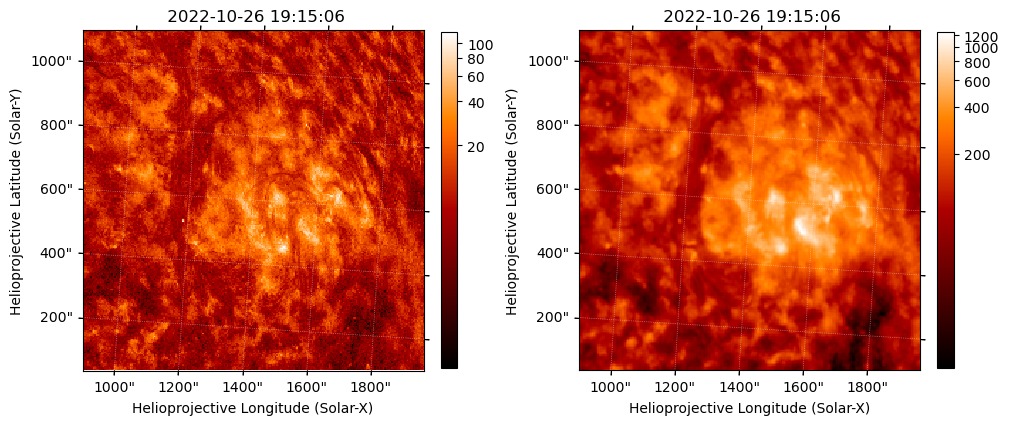

In [21]:
fig = plt.figure(figsize=(10,5),constrained_layout=True)

ax1 = fig.add_subplot(121,projection=aia_304_map_repro)
im1 = aia_304_map_repro.plot()
plt.colorbar(ax=ax1,shrink=0.75)

ax2 = fig.add_subplot(122,projection=fsi_304_crop)
im2 = fsi_304_crop.plot()
plt.colorbar(ax=ax2,shrink=0.75)

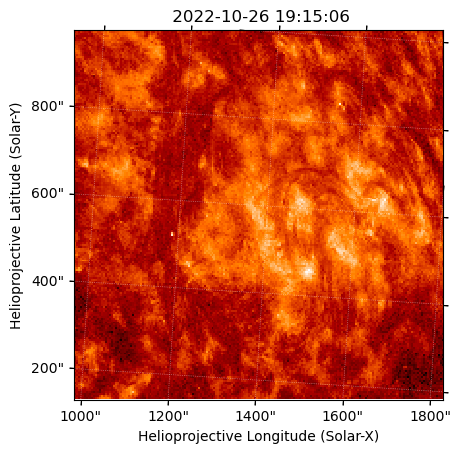

In [22]:
aia_304_map_repro_cut = aia_304_map_repro.submap([20,20]*u.pix,
                                                    top_right=[aia_304_map_repro.data.shape[1]-30,
                                                               aia_304_map_repro.data.shape[0]-30]*u.pix)
aia_304_map_repro_cut.plot()

In [23]:
Txshift_aia_fsi, Tyshift_aia_fsi = coalign_shift(fsi_304_crop,aia_304_map_repro_cut)
print(Txshift_aia_fsi, Tyshift_aia_fsi)

6.3736 arcsec 0.685765 arcsec


In [24]:
fsi_304_crop_shift = fsi_304_crop.shift_reference_coord(-Txshift_aia_fsi,-Tyshift_aia_fsi)
hri_174_map_shifted_toaia = hri_174_map_shifted.shift_reference_coord(-Txshift_aia_fsi,-Tyshift_aia_fsi)

In [25]:
hri_174_map_shifted_toaia.save("../../src/coalign_map/20221026/hri_174_map_shifted_toaia.fits",overwrite=True)

In [31]:
hmi_los_map_to_aia = sunpy.map.Map("../../src/HMI/20221026/lvl15/hmi.M_45s.20221026_192015_TAI.2.magnetogram.fits")

2022-10-26T19:19:56.397


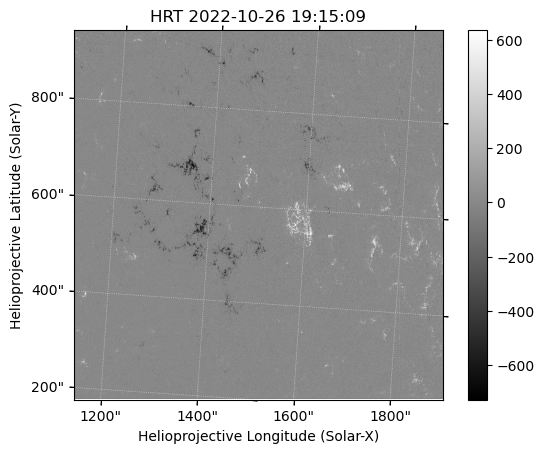

In [35]:
phi_los_map = sunpy.map.Map("../../src/PHI/20221026/solo_L2_phi-hrt-blos_20221026T191509_V01.fits")
phi_los_map.meta["rsun_ref"] = aia_171_map.meta["rsun_ref"]
print(phi_los_map.meta["date_ear"])
phi_los_map.plot()
plt.colorbar()

In [32]:
hmi_los_map_repro = hmi_los_map_to_aia.reproject_to(fsi_304_crop_shift.wcs)
hmi_los_map_repro_hrifov = hmi_los_map_to_aia.reproject_to(hri_174_map_shifted_toaia.wcs)

In [33]:
fsi_304_crop_hrifov_toaia = fsi_304_crop_shift.reproject_to(hri_174_map_shifted_toaia.wcs)

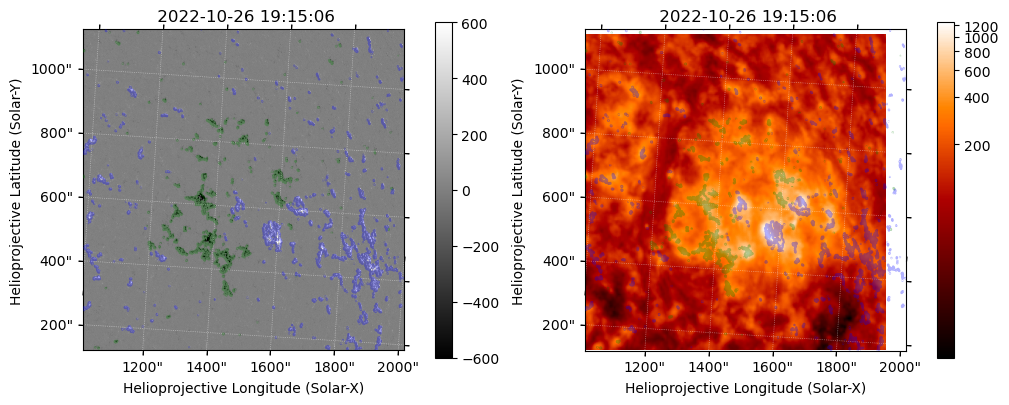

In [37]:
fig = plt.figure(figsize=(10,5),constrained_layout=True)

ax1 = fig.add_subplot(121,projection=hmi_los_map_repro_hrifov)
im1 = hmi_los_map_repro_hrifov.plot(norm=ImageNormalize(vmin=-600,vmax=600))
plt.colorbar(ax=ax1,shrink=0.75)

ax2 = fig.add_subplot(122,projection=fsi_304_crop_hrifov_toaia)
im2 = fsi_304_crop_hrifov_toaia.plot()
plt.colorbar(ax=ax2,shrink=0.75)

hmi_los_levels = [-100,100]

for ax_ in (ax1,ax2):
    bounds = ax_.axis()
    hmi_los_map_repro_hrifov.draw_contours(hmi_los_levels,colors=["g","b","r"], axes=ax_, alpha=0.3)
    ax_.axis(bounds)
    

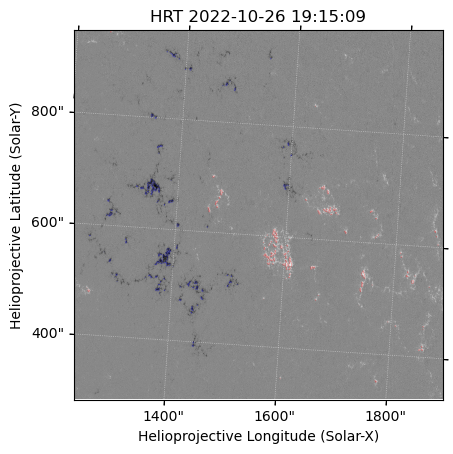

In [38]:
phi_los_map_crop = phi_los_map.submap([200,200]*u.pix,
                                      top_right=[1847,1847]*u.pix)

phi_los_map_crop.plot()
phi_los_map_crop.draw_contours([-300,300]*phi_los_map_crop.unit,colors=["b","r"], alpha=0.3,linewidths=0.5)

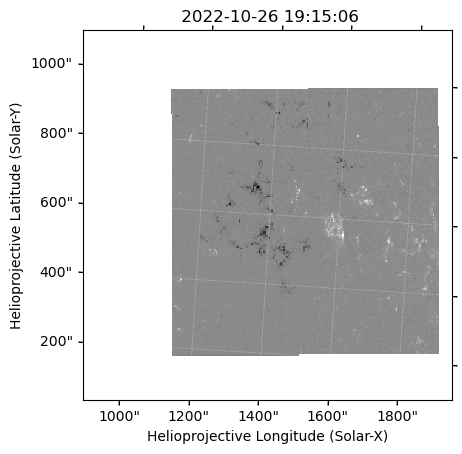

In [39]:
phi_los_map_resample = phi_los_map.reproject_to(fsi_304_crop_shift.wcs)
phi_los_map_resample.plot()

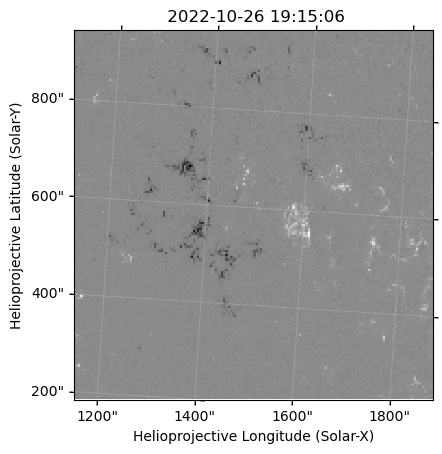

In [52]:
phi_los_map_resample_crop = phi_los_map_resample.submap([60,30]*u.pix,
                                                        top_right=[225,200]*u.pix)
phi_los_map_resample_crop.plot()

In [53]:
Txshift_phi_hmi, Tyshift_phi_hmi = coalign_shift(hmi_los_map_repro,phi_los_map_resample_crop)
print(Txshift_phi_hmi, Tyshift_phi_hmi)

-4.97248 arcsec -54.6527 arcsec


In [54]:
phi_los_map_shifted = phi_los_map.shift_reference_coord(Txshift_phi_hmi,Tyshift_phi_hmi)
phi_los_map_shifted_hrifov = phi_los_map_shifted.reproject_to(hri_174_map_shifted_toaia.wcs)
phi_los_map_resample_crop_shifted = phi_los_map_resample_crop.shift_reference_coord(Txshift_phi_hmi,Tyshift_phi_hmi)

In [58]:
SunBlinker(phi_los_map_shifted, hmi_los_map_to_aia, reproject=True, fps=1, norm2=ImageNormalize(vmin=-600,vmax=600))

In [59]:
phi_los_map_shifted.save("../../src/coalign_map/20221026/phi_los_map_shifted.fits",overwrite=True)

In [55]:
SunBlinker(phi_los_map_shifted_hrifov, hri_174_map_shifted_toaia, reproject=True, fps=1)